In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install saliency

     |████████████████████████████████| 77 kB 6.1 MB/s 


In [3]:
import os
os.chdir('/content/gdrive/My Drive/')

In [7]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P

# From our repository.
import saliency.core as saliency

%matplotlib inline

In [5]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im)
  P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im, cmap='inferno')
  P.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = im.resize((224,224))
  im = np.asarray(im)
  return im

def PreprocessImage(im):
  im = tf.keras.applications.vgg16.preprocess_input(im)
  return im

In [8]:
m = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
conv_layer = m.get_layer('block5_conv3')
model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])

553476096/553467096 [==============================] - 5s 0us/step


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            print('AA')
            tape.watch(images)
            _, output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            print('expected was not here')
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

Prediction class: 236


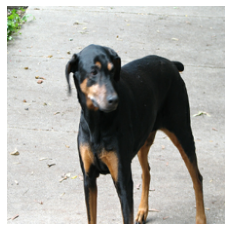

In [ ]:
# Load the image
im_orig = LoadImage('./doberman.png')
im = PreprocessImage(im_orig)

# Show the image
ShowImage(im_orig)

_, predictions = model(np.array([im]))
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236

AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA


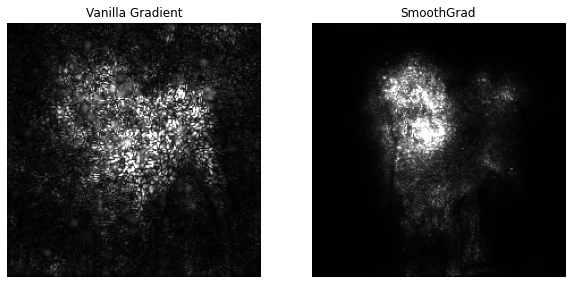

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))

In [ ]:
vanilla_mask_3d.shape

(224, 224, 3)

In [ ]:
# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()

# Baseline is a black image.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA
AA


KeyboardInterrupt: ignored